## Visualize

In [4]:
import matplotlib.pyplot as plt

def showHeatMap(grid,annotate=False,figures = None,title='',bar=False,figsize=(15,15)):
    grid =np.flip(grid,0)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(grid,cmap='viridis_r')
    
    plt.rcParams.update({'font.size': 15})
    
    if figures : grid = np.round(grid,figures)
    
    
    if annotate:
        N,M = int(grid.shape[0]),int(grid.shape[1])
        for i in range(N):
            for j in range(M):
                text = ax.text(j, i, 
                               grid[i,j],
                               ha="center", va="center", color="w")
    
    if bar :  ax.figure.colorbar(im, ax=ax)
    
    plt.title(title)
    plt.tight_layout()
    plt.xticks([]);
    plt.yticks([])
    plt.show() 

## Solver

In [2]:
import numpy as np
from numba import jit ,f8

@jit(nopython=True)
def generate_grid(n,bc,ic=0):
    #n=> Number of interior nodes

    A = np.ones((n+2,n+2),dtype=np.float32) * ic
    A[0,0]=A[-1,-1]=A[0,-1]=A[-1,0]=0
    A[0,1:-1]=bc[2]    # switch the top and bottom wall since we start the iterations from top
    A[1:-1,-1]=bc[1]
    A[-1,1:-1]=bc[0]
    A[1:-1,0]=bc[3]

    return A

@jit(nopython=True)
def update_grid_col(grid,x,n):
    #first half step update
    #x col values ;
    #n col number 
    grid[1:-1,n] = x
    return grid

@jit(nopython=True)
def update_grid_row(grid,x,n):
    #second half step update
    #x row values ;
    #n col number 
    grid[n,1:-1] = x
    return grid

@jit(nopython=True)
def calculate_first_half(A,i,j,lam):
    #calculate the ADI explicit part of the equation first half step
    if j==1 :
        return  lam * A[j][i-1] + 2 *(1-lam) * A[j][i] + lam * A[j][i+1] + lam * A[j-1][i]
    elif j== A.shape[0]-2 :
        return  lam * A[j][i-1] + 2 *(1-lam) * A[j][i] + lam * A[j][i+1] + lam * A[j+1][i]
    else  :
        return  lam * A[j][i-1] + 2 *(1-lam) * A[j][i] + lam * A[j][i+1]

@jit(nopython=True)
def calculate_second_half(A,i,j,lam):
    #calculate the ADI explicit part of the equation second half step
    if i==1 :
        return  lam * A[j-1][i] + 2 *(1-lam) * A[j][i] + lam * A[j+1][i] + lam * A[j][i-1]
    elif i== A.shape[0]-2 :
        return  lam * A[j-1][i] + 2 *(1-lam) * A[j][i] + lam * A[j+1][i] + lam * A[j][i+1]
    else  :
        return  lam * A[j-1][i] + 2 *(1-lam) * A[j][i] + lam * A[j+1][i]

@jit(nopython=True)
def generate_TDM(Lambda,N=3):
    a = np.ones(N-1,dtype=np.float32)*-Lambda 
    b =np.ones(N,dtype=np.float32) * 2*(Lambda+1) 
    return a,b,a

@jit(f8[:](f8[:],f8[:],f8[:],f8[:]))
def TDMA_solver(a0,b0,c0,d0):
    a =np.copy(a0)
    b =np.copy(b0)
    c =np.copy(c0)
    d =np.copy(d0)
    ld = len(d)

    for i in range(1,ld):
        w    = a[i-1]/b[i-1]
        b[i] = b[i]- w * c[i-1]
        d[i] = d[i] -w * d[i-1]
    
    R=b
    R[-1]=d[-1]/b[-1]
    
    for i in range(ld-2,-1,-1):
        R[i]= (d[i]-c[i]*R[i+1]) /b[i]
        
    return R

@jit(nopython=True)
def ADI_first_half_step(grid,Lambda,a,b,c):
    #apply ADI for single step

    N = grid.shape[0]

    ##First half step
    for i in range(1,N-1):

        # initialize explicit side of equation to zeros
        d = np.zeros((N-2))

        #move vertically implcitly and calculate horizontally explicitly
        for j in range(1,N-1):
            d[j-1] =calculate_first_half(grid,i,j,Lambda)

        x = TDMA_solver(a,b,c,d)

        grid = update_grid_col(grid,x,i)

    return grid

@jit(nopython=True)
def ADI_second_half_step(grid,Lambda,a,b,c):
    #apply ADI for single step

    N = grid.shape[1]

    ##Second half step
    for i in range(1,N-1):

        # initialize explicit side of equation to zeros
        d = np.zeros((N-2))

        #move horizontally implcitly and calculate vertically explicitly
        for j in range(1,N-1):
            d[j-1] =calculate_second_half(grid,j,i,Lambda)

        x = TDMA_solver(a,b,c,d)

        grid = update_grid_row(grid,x,i)

    return grid

@jit(nopython=True)
def solve(grid,Lambda=1,iters=1,steps=False) :
    if steps :
        #save intermeidate steps

        #(frames,height,width)
        grids = np.zeros((iters+1, grid.shape[0],grid.shape[1]),dtype=np.float32)
        grids[0,:,:]=grid
        a,b,c = generate_TDM(Lambda,grid.shape[0]-2)
        #apply ADI iteratively
        for i in range(1,iters+1):
            grids[i,:,:] = ADI_first_half_step(grid,Lambda,a,b,c)
            grids[i,:,:] = ADI_second_half_step(grid,Lambda,a,b,c)


    else : 
        grids = np.zeros((2,grid.shape[0],grid.shape[1]),dtype=np.float32)
        #Show final step only
        grids[0,:,:]=grid
        a,b,c = generate_TDM(Lambda,grid.shape[0]-2)
        #apply ADI iteratively
        for i in range(iters):
            grids[1,:,:] = ADI_first_half_step(grid,Lambda,a,b,c)
            grids[1,:,:] = ADI_second_half_step(grid,Lambda,a,b,c)

    return grids

## Example 

In [3]:
'''
 Solve a grid of 10x10 (boundaries inclusive) with 
 -- boundary conditions of 100 Top, 50 right , 0 botton , 75 left  
 -- initial condition of 0
 -- Kdt/(dx^2)=0.0835
 -- time step = 1000
'''

'\n Solve a grid of 50x50 with \n -- boundary conditions of 100 Top, 50 right , 0 botton , 75 left  \n -- initial condition of 0\n -- Kdt/(dx^2)=0.0835\n -- time step = 10\n'

### Generate grid

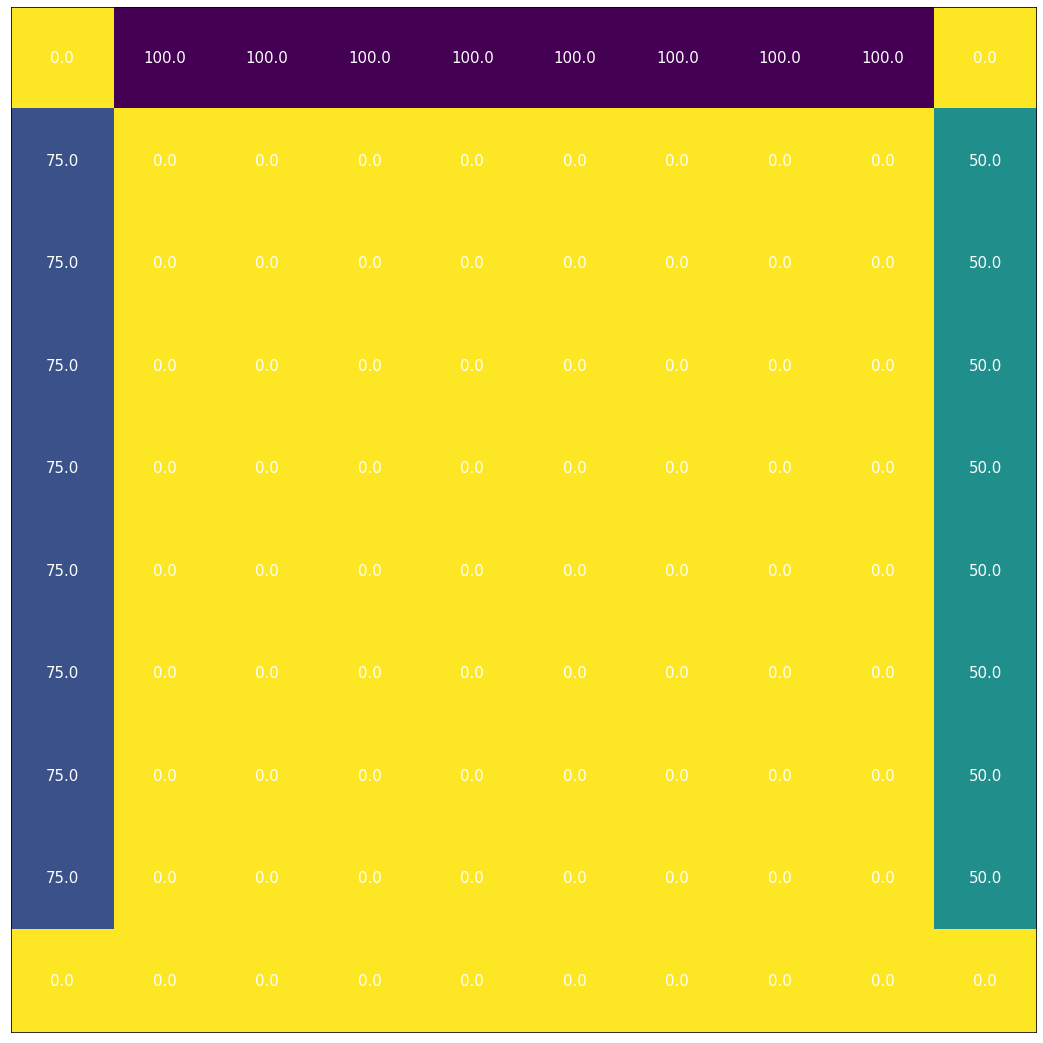

In [22]:
grid = generate_grid(n = 8 , bc=(100,50,0,75) , ic=0)
showHeatMap(grid,annotate=True,figsize=(15,15))

### Solve 

In [19]:
'''
steps = Save intermeidate steps in the solution array

solution is in shape of [time_step , rows , cols]

'''

%time solution = solve(grid,Lambda=0.0835,iters=1000,steps = True)

Wall time: 17 ms


### Show result

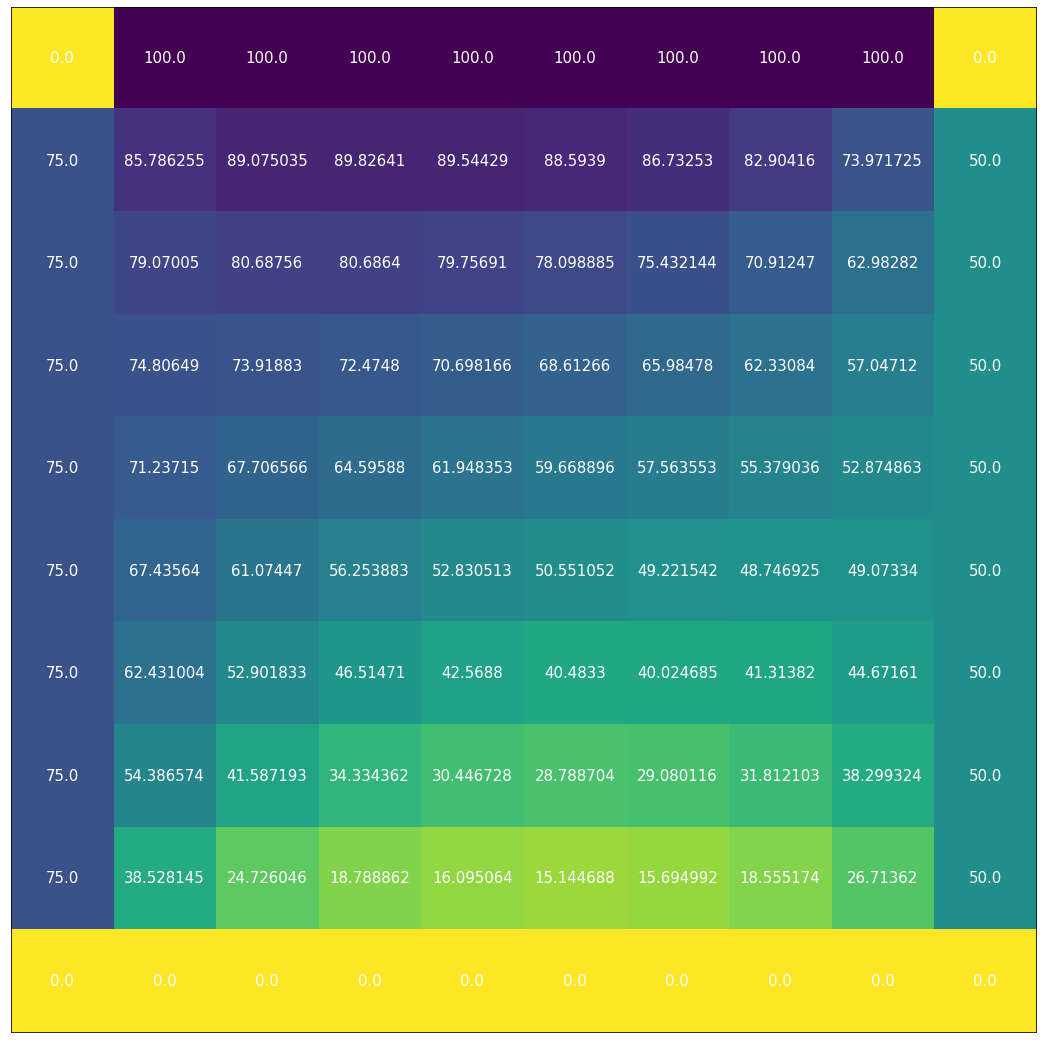

In [21]:
time_step = 50

showHeatMap(solution[time_step,:,:], annotate=True,figsize=(15,15))